In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib as mpl
import numpy.ma as ma
from scipy import interpolate
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def get_vels(dirname, fname, meshmaskname, time_s, time_f):
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    print('files')
    
    if fname == 'MCKNZ_1h*':
        y,x = slice(0,-2,None), slice(0,-2,None)
    elif fname == '1_MCKNZ_1h*':
        y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW, scDataset(filesT) as dsT:
        vozocrtx0 = dsU.variables['vozocrtx'][time_s:time_f,:,y,x]
        vomecrty0 = dsV.variables['vomecrty'][time_s:time_f,:,y,x]
        vovecrtz0 = dsW.variables['vovecrtz'][time_s:time_f,:,y,x]
        vosaline0 = dsT.variables['vosaline'][time_s:time_f, :, y, x]
        sozotaux = dsU.variables['sozotaux'][time_s:time_f,0,0]
        depthu = dsU.variables['depthu'][:]
        deptht = dsT.variables['deptht'][:]

    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,:,y,x]
        vmask0 = dsM.variables['vmask'][0,:,y,x]
        tmask0 = dsM.variables['tmask'][0,:,y,x]
        tmask_ss0 = dsM.variables['tmask'][0, 0, y, x]
        e3t = dsM.variables['e3t_0'][0, :, 0, 0]
        
        e1t0 = np.nanmean(dsM.variables['e1t'][0, y, x], axis=0)
        e2t0 = np.nanmean(dsM.variables['e2t'][0, y, x], axis=1)
        e1t = np.cumsum(e1t0) / 1000 # km
        e2t = np.cumsum(e2t0) / 1000 # km
        
        e1v = dsM.variables['e1v'][0, y, x]
        e2u = dsM.variables['e2u'][0, y, x]

    umask = np.tile(umask0, (len(sozotaux), 1, 1))
    vmask = np.tile(vmask0, (len(sozotaux), 1, 1))
    tmask = np.tile(tmask0, (len(sozotaux), 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vozocrtx, vomecrty, vovecrtz, vosaline, umask, vmask, tmask, depthu, deptht, e1t, e2t, e3t, e1v, e2u, sozotaux

In [3]:
def get_salt_daily(time_s, fname, meshmaskname):
    time_f = time_s+24
    vozocrtx, vomecrty, vovecrtz, vosaline, umask, vmask, tmask, depthu, deptht, e1t, e2t, e3t, e1v, e2u, sozotaux = get_vels(dirname, fname, meshmaskname, time_s, time_f)
    vosaline_daily = np.mean(vosaline, axis=0)
    vozocrtx_daily = np.mean(vozocrtx, axis=0)
    vomecrty_daily = np.mean(vomecrty, axis=0)
    vovecrtz_daily = np.mean(vovecrtz, axis=0)
    return vosaline_daily, vozocrtx_daily, vomecrty_daily, vovecrtz_daily, depthu, deptht, e1t, e2t, e3t, e1v, e2u

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def get_varb_surf(vosaline_array, salt, varb):
    
    if len(vosaline_array.shape)==1:
        f = interpolate.interp1d(vosaline_array, varb)
        ynew = f(salt)
        varb_array = ynew
        
    elif len(vosaline_array.shape)!=1:
        varb_array = np.full([vosaline_array.shape[-2], vosaline_array.shape[-1]], np.nan)
        for i in range(vosaline_array.shape[-1]):
            for j in range(vosaline_array.shape[-2]):
                vosaline_column = vosaline_array[:, j, i]
                if len(varb.shape)==1:
                    varb_column = varb
                elif len(varb.shape)==3:
                    varb_column = varb[:, j, i]

                try:
                    f = interpolate.interp1d(vosaline_column, varb_column)
                    ynew = f(salt)
                    varb_array[j, i] = ynew
                except ValueError:
                    varb_array[j, i] = np.nan  
                
    return varb_array

In [4]:
def plot_winds_currents(ax, filename_winds, filename_currents):
    fs_numb, fs_str = 25, 30
    axt = ax.twinx()

    winds = np.loadtxt(filename_winds, delimiter=",")
    currents = np.loadtxt(filename_currents, delimiter=",")

    wind = winds[1]
    current = general_functions.smooth(currents[1], 12)

    c_wind = '#F95738'
    c_current = '#38618C' #EE964B 7E5A9B EE6352
    
    lns1 = ax.plot(wind, c=c_wind, lw=3.5, ls='--', label='wind stress')
    lns2 = axt.plot(current, c=c_current, lw=3.5, ls='-', label='alongshore velocity')
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4, ncol=2, fontsize=fs_str)

    ax.set_xlabel('Time [hours]', fontsize=fs_str)
    ax.xaxis.set_ticks(np.arange(24, 6*24, 24))
    ax.set_xlim([0, 6*24])
    
    ax.set_ylabel('Wind stress\n[Nm$^{-2}$]', fontsize=fs_str)
    min_y = -1.2
    ax.yaxis.set_ticks(np.linspace(0, min_y, 4))
    ax.set_ylim([min_y, 0])
    ax.spines['left'].set_color(c_wind)
    ax.yaxis.label.set_color(c_wind)
    
    axt.set_ylabel('Alongshore\nvelocity [ms$^{-1}$]', rotation=270, fontsize=fs_str, labelpad=70)
    axt.yaxis.set_ticks(np.arange(0, -0.4, -0.1))
    axt.set_ylim([-0.3, 0])
    axt.spines['left'].set_color(c_current)
    axt.yaxis.label.set_color(c_current)
    
    ax.grid(which='major', axis='both', linestyle='-')
    ax.tick_params(axis='both', which='both', length=0, labelsize=fs_numb)
    axt.tick_params(axis='both', which='both', length=0, labelsize=fs_numb)
    
    ax.add_patch(patches.Rectangle((0, min_y), (5), (0.28),
                                   fc='w', ec='k', lw=1.5, alpha=1))
    ax.annotate('g', xy=(2.6,-1.05),
                fontsize=fs_str, weight='bold', va='center', ha='center')
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    
    return ax

In [5]:
def plot_speeds(ax, salt, vosaline_c, vosaline_p, 
                vozocrtx_c, vozocrtx_p, vomecrty_c, vomecrty_p,
                e1t_c, e2t_c, e1t_p, e2t_p, inds,
                depth_initial, vm2):
    fs_numb, fs_str = 25, 30
    
    cmap = cmo.cm.matter
    cmap.set_bad('#A69F98')
    arrow=1
    
    u_daily_c = get_varb_surf(vosaline_c, salt, vozocrtx_c)
    v_daily_c = get_varb_surf(vosaline_c, salt, vomecrty_c)
    x_slice_c, y_slice_c, u_nstg_c, v_nstg_c, speeds_c = quicklook.get_speeds(u_daily_c, v_daily_c, arrow)
    
    u_daily_p = get_varb_surf(vosaline_p, salt, vozocrtx_p)
    v_daily_p = get_varb_surf(vosaline_p, salt, vomecrty_p)
    x_slice_p, y_slice_p, u_nstg_p, v_nstg_p, speeds_p = quicklook.get_speeds(u_daily_p, v_daily_p, arrow)
    
    x_left, y_bottom = e1t_p[inds[0]], e2t_p[inds[1]]
    x_shift, y_shift = x_left+e1t_c, y_bottom+e2t_c
    
    arr = 4
    x_points_p, y_points_p = e1t_p[x_slice_p], e2t_p[y_slice_p]
    p = ax.pcolormesh(x_points_p, y_points_p, speeds_p, cmap=cmap, vmin=vm0[0], vmax=vm0[1], zorder=1)
    ax.quiver(x_points_p[::arr], y_points_p[::arr], u_nstg_p[::arr, ::arr], v_nstg_p[::arr, ::arr],
              color='k', pivot='mid', clim=[vm0[0], vm0[1]], 
              width=0.0045, headwidth=2.5, minlength=1.2, zorder=2)
     
    arr = 12
    x_points_c, y_points_c = x_shift[x_slice_c], y_shift[y_slice_c]
    p = ax.pcolormesh(x_points_c, y_points_c, speeds_c, cmap=cmap, vmin=vm0[0], vmax=vm0[1], zorder=3)
    ax.quiver(x_points_c[::arr], y_points_c[::arr], u_nstg_c[::arr, ::arr], v_nstg_c[::arr, ::arr],
              color='k', pivot='mid', clim=[vm0[0], vm0[1]], 
              width=0.0045, headwidth=2.5, minlength=1.2, zorder=4)
    
    where_min = np.where(speeds_c == np.nanmin(speeds_c))
    where_max = np.where(speeds_c == np.nanmax(speeds_c))
    
    for n in range(len(where_max[0])):
        ax.scatter(x_shift[where_max[1]], y_shift[where_max[0]], 
                   c='#284CED', edgecolors='w', marker='D', s=100, alpha=0.9, zorder=5)  
        
    ax.contour(e1t_p, e2t_p, bathy_p, levels=depth_initial, colors='k', alpha=0.9, linewidths=2, zorder=6)
    ax.contour(x_shift, y_shift, bathy_c, levels=depth_initial, colors='k', alpha=0.9, linewidths=2, zorder=7)
    
    print(np.round(np.nanmin(speeds_c),2), np.round(np.nanmax(speeds_c),2))
    
    return ax, p

In [6]:
def plot_upwelling(ax, salt, vosaline_c, vosaline_p, deptht_c, deptht_p,
                   e1t_c, e2t_c, e1t_p, e2t_p, inds,
                   depth_initial, vm2):
    fs_numb, fs_str = 25, 30
    
    norm = upwelling_functions.MidpointNormalize(midpoint=0)
    cmap = cmo.cm.delta_r
    cmap.set_bad('#A69F98')
    levels = [-5, 10, 20, 40, 60, 80]
    
    disp_daily_c = depth_initial - get_varb_surf(vosaline_c, salt, deptht_c)
    disp_daily_p = depth_initial - get_varb_surf(vosaline_p, salt, deptht_p)
    
    x_left, y_bottom = e1t_p[inds[0]], e2t_p[inds[1]]
    x_shift, y_shift = x_left+e1t_c, y_bottom+e2t_c
    
    ax.pcolormesh(e1t_p, e2t_p, disp_daily_p, cmap=cmap, norm=norm, vmin=vm2[0], vmax=vm2[1], zorder=1)
    ax.contour(e1t_p, e2t_p, disp_daily_p, levels=levels, colors='k', alpha=0.7, linewidths=0.5, zorder=2)
    
    p = ax.pcolormesh(x_shift, y_shift, disp_daily_c, cmap=cmap, norm=norm, vmin=vm2[0], vmax=vm2[1], zorder=3)
    cs = ax.contour(x_shift, y_shift, disp_daily_c, levels=levels, colors='k', alpha=0.7, linewidths=0.5, zorder=4)
    
    ax.clabel(cs, inline=1, fontsize=fs_numb*0.8, fmt ='%1.f', colors='k')
    
    where_min = np.where(disp_daily_c == np.nanmin(disp_daily_c))
    where_max = np.where(disp_daily_c == np.nanmax(disp_daily_c))
    for n in range(len(where_max[0])):
        ax.scatter(x_shift[where_max[1]], y_shift[where_max[0]], c='orangered', edgecolors='w', marker='D', s=100, alpha=0.9, zorder=7)
    
    ax.contour(e1t_p, e2t_p, bathy_p, levels=depth_initial, colors='k', alpha=0.9, linewidths=2, zorder=5)
    ax.contour(x_shift, y_shift, bathy_c, levels=depth_initial, colors='k', alpha=0.9, linewidths=2, zorder=6)
    
    print(np.round(np.nanmin(disp_daily_c),2), np.round(np.nanmax(disp_daily_c),2))
    
    return ax, p

In [7]:
def plot_wave(ax, salt, vosaline_c, vovecrtz_c, vosaline_p, vovecrtz_p, 
              e1t_c, e2t_c, e1t_p, e2t_p, inds,
              depth_initial, vm1):
    
    cmap = cmo.cm.balance
    cmap.set_bad('#A69F98')
    
    w_daily_c = get_varb_surf(vosaline_c, salt, vovecrtz_c) * 1000
    w_daily_p = get_varb_surf(vosaline_p, salt, vovecrtz_p) * 1000
    
    x_left, y_bottom = e1t_p[inds[0]], e2t_p[inds[1]]
    print('x_left, y_bottom', x_left, y_bottom)
    x_shift, y_shift = x_left+e1t_c, y_bottom+e2t_c
    
    ax.pcolormesh(e1t_p, e2t_p, w_daily_p, cmap=cmap, vmin=vm1*-1, vmax=vm1, zorder=1)
    p = ax.pcolormesh(x_shift, y_shift, w_daily_c, cmap=cmap, vmin=vm1*-1, vmax=vm1, zorder=2)
    
    ax.contour(e1t_p, e2t_p, bathy_p, levels=depth_initial, colors='k', alpha=0.9, linewidths=2, zorder=3)
    ax.contour(x_shift, y_shift, bathy_c, levels=depth_initial, colors='k', alpha=0.9, linewidths=2, zorder=4)
    
    print(np.round(np.nanmin(w_daily_c),2), np.round(np.nanmax(w_daily_c),2))
        
    print('xleft', x_left, 'ybottom', y_bottom, 'xlast', e1t_p[-1], 'ylast', e2t_p[-1])
    return ax, p

In [8]:
def plot_vorticity(ax, salt, vosaline_c, vosaline_p, 
                   vozocrtx_c, vozocrtx_p, vomecrty_c, vomecrty_p,
                   e1v_c, e1v_p, e2u_c, e2u_p,
                   e1t_c, e2t_c, e1t_p, e2t_p, inds,
                   depth_initial, vm):
    
    cmap = cmo.cm.balance
    cmap.set_bad('#A69F98')
    
    u_daily_c = get_varb_surf(vosaline_c, salt, vozocrtx_c)
    v_daily_c = get_varb_surf(vosaline_c, salt, vomecrty_c)
    
    u_daily_p = get_varb_surf(vosaline_p, salt, vozocrtx_p)
    v_daily_p = get_varb_surf(vosaline_p, salt, vomecrty_p)
    
    dV_c = np.diff(v_daily_c, axis=-1)
    dx_c = e1v_c[..., :-1]
    dVdx_c = dV_c/dx_c
    
    dV_p = np.diff(v_daily_p, axis=-1)
    dx_p = e1v_p[..., :-1]
    dVdx_p = dV_p/dx_p
    
    dU_c = np.diff(u_daily_c, axis=-2)
    dy_c = e2u_c[:-1, ...]
    dUdy_c = dU_c/dy_c
    
    dU_p = np.diff(u_daily_p, axis=-2)
    dy_p = e2u_p[:-1, ...]
    dUdy_p = dU_p/dy_p

    zeta_c = dVdx_c[:-1, ...] - dUdy_c[..., :-1]
    zeta_p = dVdx_p[:-1, ...] - dUdy_p[..., :-1]
    #zeta = np.ma.array(zeta0, mask = 1 - umask[:-1, :-1])
    
    x_left, y_bottom = e1t_p[inds[0]], e2t_p[inds[1]]
    x_shift, y_shift = x_left+e1t_c, y_bottom+e2t_c
    
    ax.pcolormesh(e1t_p, e2t_p, zeta_p, cmap=cmap, vmin=vm*-1, vmax=vm, zorder=1)
    p = ax.pcolormesh(x_shift, y_shift, zeta_c, cmap=cmap, vmin=vm*-1, vmax=vm, zorder=1)
    
    return ax, p

In [9]:
def plot(kind, time_s_day_all, salt, vm0, vm1, vm2, tk0, tk1, tk2, flag):
    
    fs_numb, fs_str = 25, 30
    
    fig = plt.figure(figsize=(20, 24))
    gs = gridspec.GridSpec(7, 2, width_ratios=[1,1], height_ratios=[1,1,1,0.1,0.1,0.1,0.5])
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[2, 0])
    axc0 = plt.subplot(gs[4, 0])

    ax4 = plt.subplot(gs[0, 1])
    ax5 = plt.subplot(gs[1, 1])
    ax6 = plt.subplot(gs[2, 1])
    axc1 = plt.subplot(gs[4, 1])

    axoff = plt.subplot(gs[3,:]); axoff.axis('off')
    axoff = plt.subplot(gs[5,:]); axoff.axis('off')
    axlong = plt.subplot(gs[6,:])

    if kind == 'ideal':
        mid = 306
    elif kind == 'real':
        mid = 400

    for ax in ([ax1, ax2, ax4, ax5]):
        ax.xaxis.set_tick_params(labelbottom=False)
    for ax in ([ax4, ax5, ax6]):
        ax.yaxis.set_tick_params(labelbottom=False)
    
    # imin, jmin
    if kind == 'ideal':
        inds = [90, 10]
    elif kind == 'real':
        inds = [130, 10]
    
    rows = [[ax1, ax4], [ax2, ax5], [ax3, ax6]]
    axcs = [axc0, axc1]
    labs = [['a','b','c'], ['d','e','f']]
    
    for nrow in range(3):
        
        row = rows[nrow]
        
        fname = 'MCKNZ_1h*'
        meshmaskname = 'mesh_mask.nc'
        vosaline_p, vozocrtx_p, vomecrty_p, vovecrtz_p, depthu_p, deptht_p, e1t_p, e2t_p, e3t_p, e1v_p, e2u_p= get_salt_daily(time_s_day_all[nrow], fname, meshmaskname)
        
        fname = '1_MCKNZ_1h*'
        meshmaskname = '1_mesh_mask.nc'
        vosaline_c, vozocrtx_c, vomecrty_c, vovecrtz_c, depthu_c, deptht_c, e1t_c, e2t_c, e3t_c, e1v_c, e2u_c= get_salt_daily(time_s_day_all[nrow], fname, meshmaskname)

        
        for ncol in range(2):
                        
            ax = row[ncol]
            
            min_x, max_x, min_y, max_y = mid-150, mid+150, 20, 210
            
            ind_y = 185
            ind_y_mid = ind_y + (max_y-ind_y)*0.5
            ax.add_patch(patches.Rectangle((min_x, ind_y),(max_y-ind_y),(max_y-ind_y), 
                                           fc='w', ec='k', lw=1.5, alpha=1, zorder=8))
            ax.annotate(labs[ncol][nrow], xy=(min_x+(max_y-ind_y)*0.5, ind_y_mid),
                        fontsize=fs_str, weight='bold', va='center', ha='center', zorder=9)
            ttl = 'Hours '+str(time_s_day_all[nrow]+1)+'-'+str(time_s_day_all[nrow]+24+1)

            # Initial depth
            depth_initial = get_varb_surf(vosaline_ref_profile, salt, deptht_c)
            print(time_s_day_all[nrow], nrow, np.round(depth_initial, 2))
            
            # Particular day
            if ncol == 0 and flag == 'a': 
                ticks = tk0
                cbar_lab = 'Speeds [ms$^{-1}$]'
                ax, p = plot_speeds(ax, salt, vosaline_c, vosaline_p, 
                                    vozocrtx_c, vozocrtx_p, vomecrty_c, vomecrty_p,
                                    e1t_c, e2t_c, e1t_p, e2t_p, inds,
                                    depth_initial, vm0)
                
            elif ncol == 1 and flag == 'a':
                vmv = 0.0001
                ticks = [-0.0001, -0.00005, 0, 0.00005, 0.0001]
                cbar_lab = 'Relative vorticity [s$^{-1}$]'
                ax, p = plot_vorticity(ax, salt, vosaline_c, vosaline_p, 
                                       vozocrtx_c, vozocrtx_p, vomecrty_c, vomecrty_p,
                                       e1v_c, e1v_p, e2u_c, e2u_p,
                                       e1t_c, e2t_c, e1t_p, e2t_p, inds,
                                       depth_initial, vmv)
                 
            elif ncol == 0 and flag == 'b':
                ticks = tk1
                cbar_lab = 'Vertical velocity [mms$^{-1}$]'
                ax, p = plot_wave(ax, salt, vosaline_c, vovecrtz_c, vosaline_p, vovecrtz_p, 
                                  e1t_c, e2t_c, e1t_p, e2t_p, inds,
                                  depth_initial, vm1)
                
            elif ncol == 1 and flag == 'b':
                ticks = tk2
                cbar_lab = 'Vertical displacement [m]'
                ax, p = plot_upwelling(ax, salt, vosaline_c, vosaline_p, deptht_c, deptht_p,
                                       e1t_c, e2t_c, e1t_p, e2t_p, inds,
                                       depth_initial, vm2)
            
            
            ax.xaxis.set_ticks(np.arange(int(round(min_x/50)*50)+50, 600, 50))
            ax.tick_params(axis='both', which='both', length=0, labelsize=fs_numb)
            ax.set_aspect(aspect='equal')
            ax.set_xlim([min_x, max_x])
            ax.set_ylim([min_y, max_y])
            ax.set_title(ttl, fontsize=fs_str)
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(2)

            if nrow==2: ax.set_xlabel('Alongshore (x) distance [km]', fontsize=fs_str, labelpad=15)
            else:pass

            if ncol==0:
                ax.set_ylabel('Cross-shore (y)\ndistance [km]', fontsize=fs_str, labelpad=15)

            if nrow==2:
                cbar = fig.colorbar(p, cax=axcs[ncol], orientation='horizontal')
                cbar.ax.tick_params(labelsize=fs_numb)
                cbar.set_ticklabels(ticks)
                cbar.set_ticks(ticks)
                cbar.ax.set_xlabel(cbar_lab, rotation=0, fontsize=fs_str)
                cbar.ax.get_yaxis().labelpad = 50   
                
    if kind == 'ideal':
        filename_currents = './files/currents_ideal.out'
        filename_winds = './files/winds_ideal.out'
    elif kind == 'real':
        filename_currents = './files/currents_real.out'
        filename_winds = './files/winds_real.out'
    ax = plot_winds_currents(axlong, filename_winds, filename_currents)
    
    fig.tight_layout()
    fig.patch.set_facecolor('white')    
    plt.subplots_adjust(top=0.99, wspace=0.05, hspace=0.2)
    
    return fig

# Constants

In [10]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

time_s_day1 = 24*0 + 11# day 1
time_s_day2 = 24*1 + 11# day 2
time_s_day4 = 24*3 + 11# day 4

time_s_day_all = [time_s_day1, time_s_day2, time_s_day4]

# LANSARD ET AL.: WATER MASSES IN THE BEAUFORT SEA 
# https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2011JC007299

salt_UHW_SA, salt_ATW_SA = 33.26258156425155, 34.99102991139694

In [11]:
vm0_UHW = [0, 0.65]
tk0_UHW = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
vm0_ATW = [0, 0.2]
tk0_ATW = [0.  , 0.05, 0.1 , 0.15, 0.2 ]

vm1_UHW = 1.1
vm1_ATW = vm1_UHW
tk1_UHW = [-1. , -0.5,  0. ,  0.5,  1. ]
tk1_ATW = tk1_UHW

vm2_UHW = [-10, 100]
vm2_ATW = [-5, 120]
tk2_UHW = [-10, 0, 20, 40, 60, 80, 100, 120]
tk2_ATW = tk2_UHW

# Ideal

In [12]:
kind = 'ideal'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

bathy_c = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/1_ideal_bathy_for_agrif.nc')['Bathymetry'][1:-1, 1:-1]
bathy_p = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')['Bathymetry'][:-2, :-2]

----------
### UHW

files
files
11 0 119.44
0.0 0.69
11 0 119.44
files
files
35 1 119.44
0.0 0.66
35 1 119.44
files
files
83 2 119.44
0.0 0.6
83 2 119.44


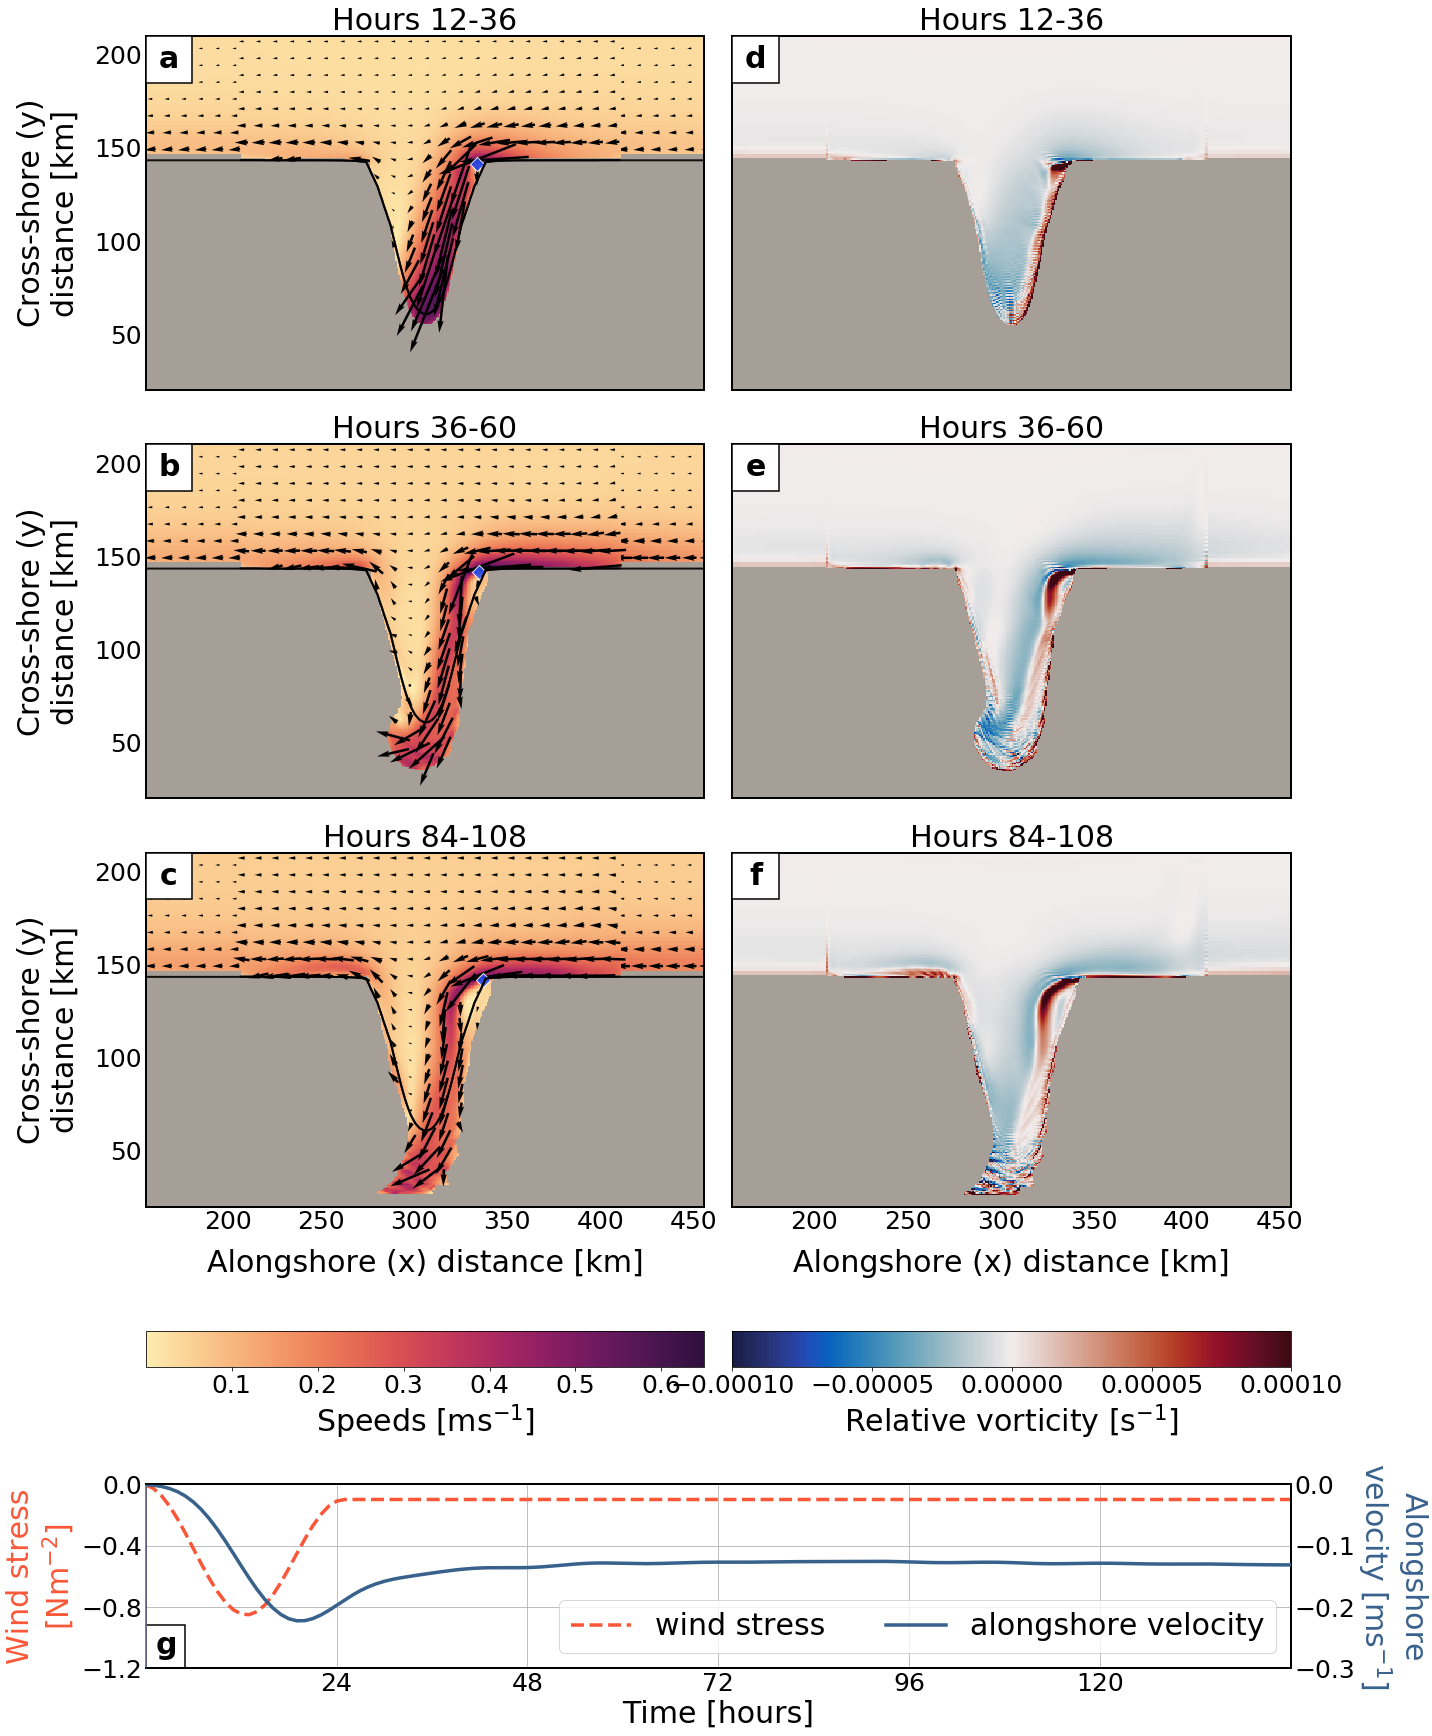

In [13]:
flag = 'a'
salt = salt_UHW_SA
vm0, vm1, vm2, tk0, tk1, tk2 = vm0_UHW, vm1_UHW, vm2_UHW, tk0_UHW, tk1_UHW, tk2_UHW
fig = plot(kind, time_s_day_all, salt, vm0, vm1, vm2, tk0, tk1, tk2, flag)
fig.savefig('./fig_UHW_ideal_'+flag+'.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

----------
### AW

files
files
11 0 469.71
0.01 0.2
11 0 469.71
files
files
35 1 469.71
0.0 0.21
35 1 469.71
files
files
83 2 469.71
0.01 0.08
83 2 469.71


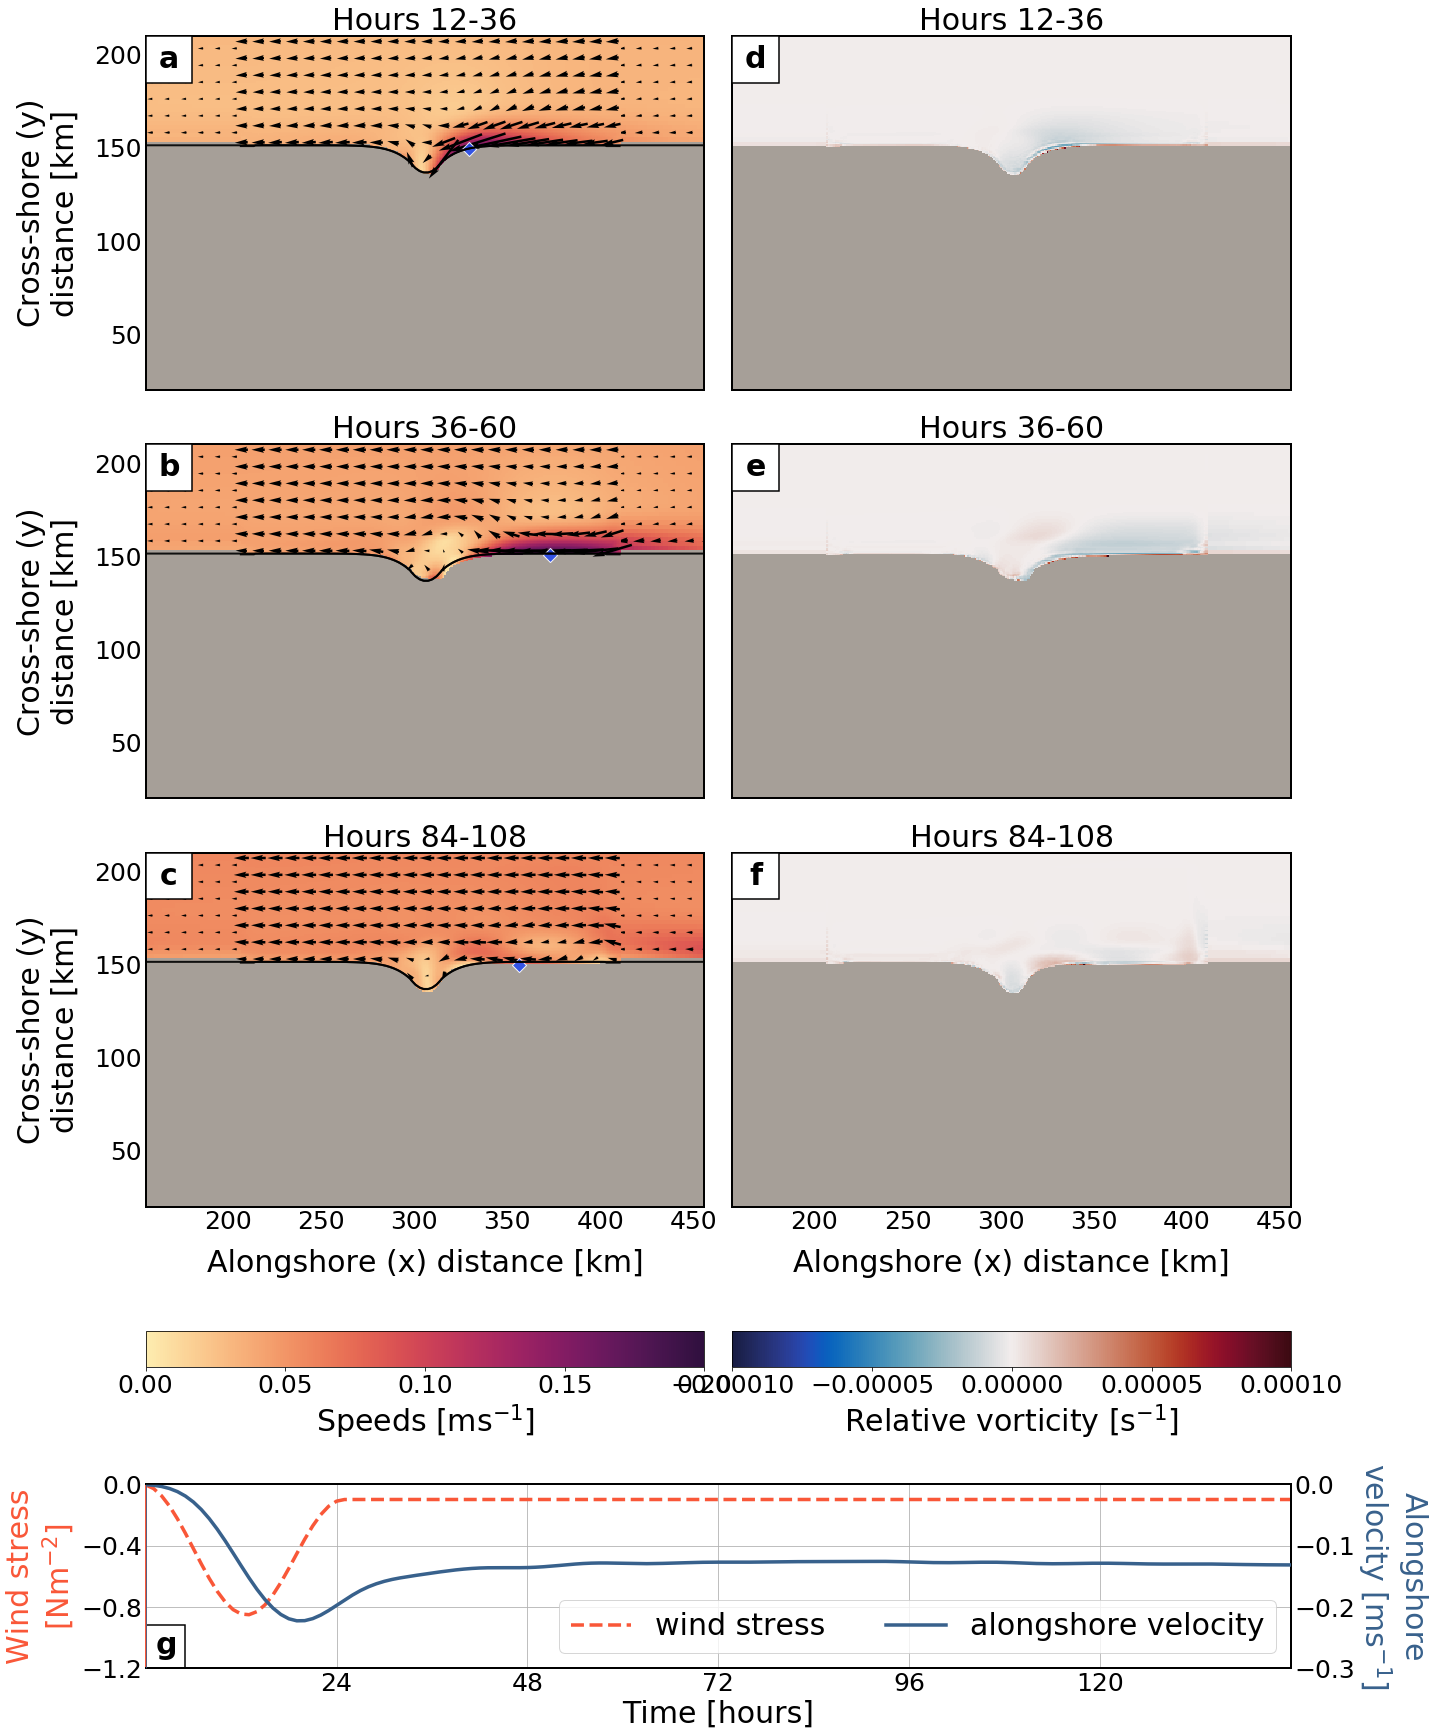

In [14]:
flag = 'a'
salt = salt_ATW_SA
vm0, vm1, vm2, tk0, tk1, tk2 = vm0_ATW, vm1_ATW, vm2_ATW, tk0_ATW, tk1_ATW, tk2_ATW
fig = plot(kind, time_s_day_all, salt, vm0, vm1, vm2, tk0, tk1, tk2, flag)
fig.savefig('./fig_AW_ideal_'+flag+'.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

# Real

In [15]:
kind = 'real'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

bathy_c = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_base/1_real_bathy_for_agrif_fix.nc')['Bathymetry'][1:-1, 1:-1]
bathy_p = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/realistic/real_bathy_for_agrif.nc')['Bathymetry'][:-2, :-2]

----------
### UHW

files
files
11 0 119.44
0.01 0.51
11 0 119.44
files
files
35 1 119.44
0.01 0.52
35 1 119.44
files
files
83 2 119.44
0.0 0.44
83 2 119.44


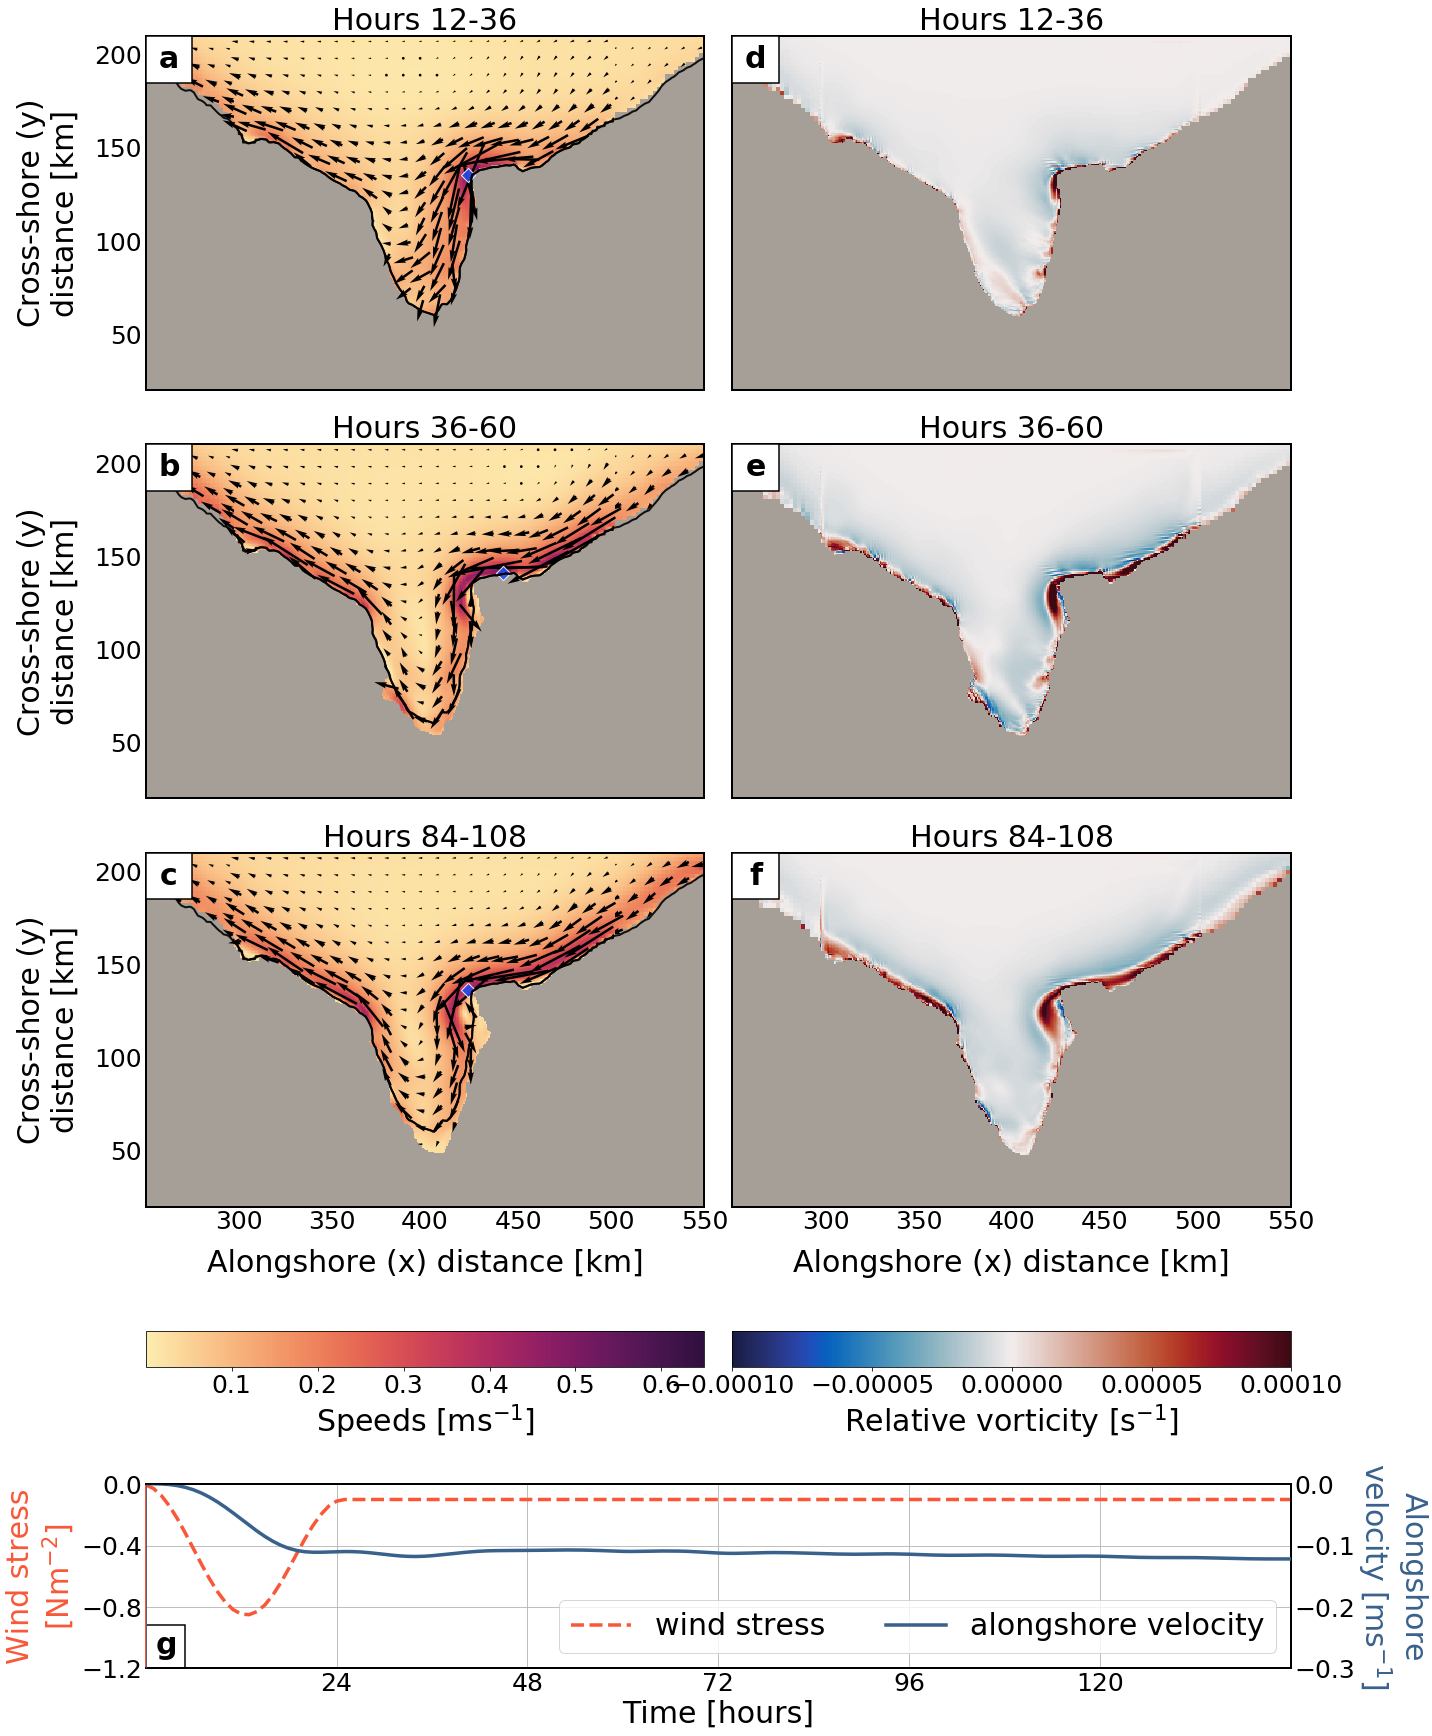

In [16]:
flag = 'a'
salt = salt_UHW_SA
vm0, vm1, vm2, tk0, tk1, tk2 = vm0_UHW, vm1_UHW, vm2_UHW, tk0_UHW, tk1_UHW, tk2_UHW
fig = plot(kind, time_s_day_all, salt, vm0, vm1, vm2, tk0, tk1, tk2, flag)
fig.savefig('./fig_UHW_real_'+flag+'.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

----------
### AW

files
files
11 0 469.71
0.0 0.19
11 0 469.71
files
files
35 1 469.71
0.0 0.21
35 1 469.71
files
files
83 2 469.71
0.0 0.11
83 2 469.71


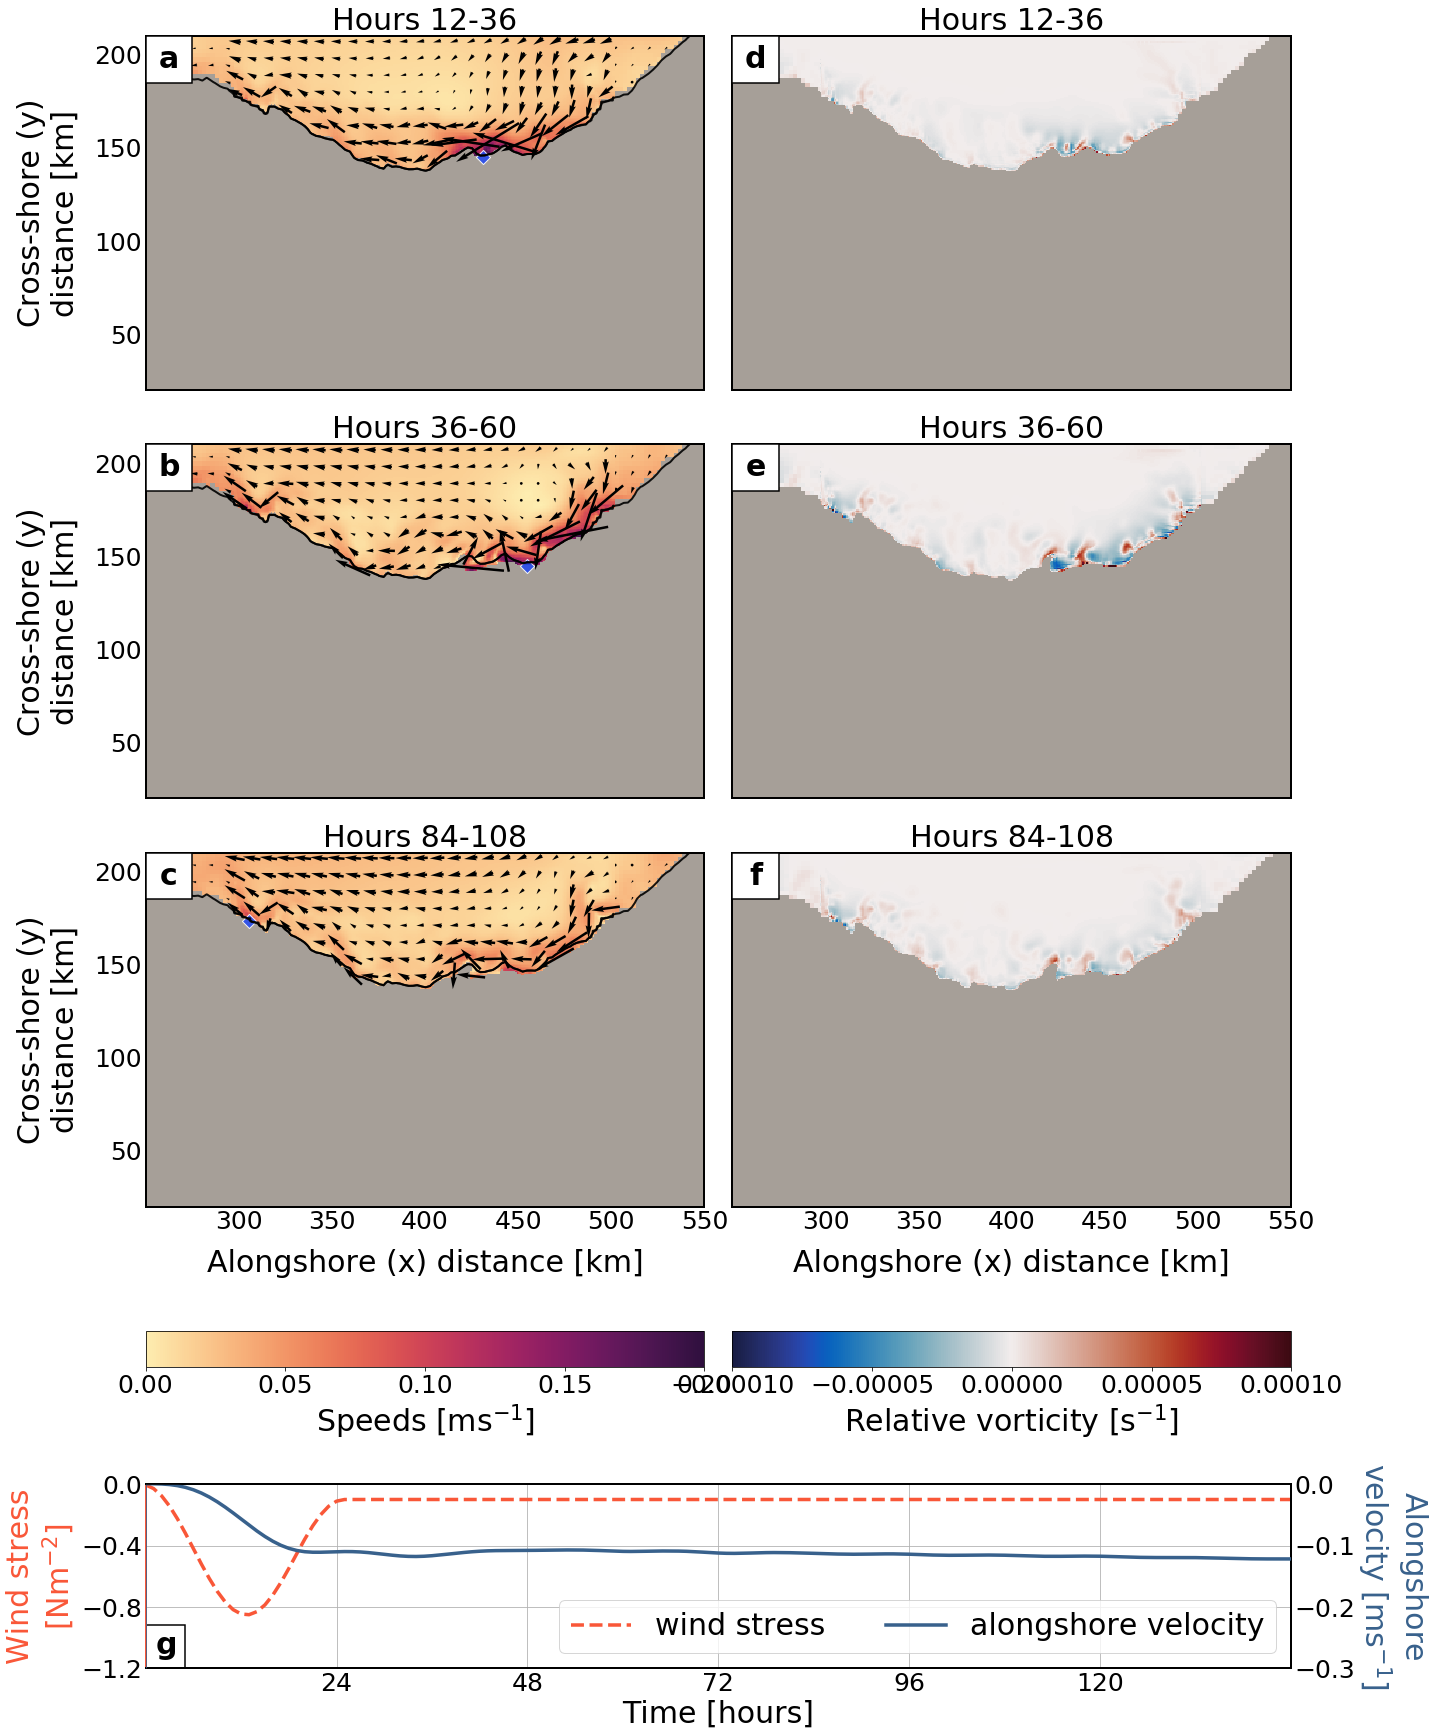

In [17]:
flag = 'a'
salt = salt_ATW_SA
vm0, vm1, vm2, tk0, tk1, tk2 = vm0_ATW, vm1_ATW, vm2_ATW, tk0_ATW, tk1_ATW, tk2_ATW
fig = plot(kind, time_s_day_all, salt, vm0, vm1, vm2, tk0, tk1, tk2, flag)
fig.savefig('./fig_AW_real_'+flag+'.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())